## Configurations for Colab

In [1]:
import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !apt install python-opengl
    !apt install ffmpeg
    !apt install xvfb
    !pip install pyvirtualdisplay
    !pip install -U gym
    from pyvirtualdisplay import Display
    
    # Start virtual display
    dis = Display(visible=0, size=(400,400))
    dis.start()

## Categorial DQN

In [2]:
import os 
from typing import Dict, List, Tuple

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output

In [3]:
class ReplayBuffer:
    """A simple numpy replay buffer"""
    
    def __init__(self,obs_dim: int,size: int,batch_size: int = 32):
        self.obs_buf = np.zeros([size,obs_dim],dtype=np.float32) # 观测的当前状态的大小 X 每一个观测状态reshape后的维度
        self.next_obs_buf = np.zeros([size,obs_dim],dtype=np.float32) # 观测的下一状态的大小 X 每一个观测的下一状态reshape后的维度
        self.acts_buf = np.zeros([size],dtype=np.float32) # 记录状态变迁的过程中具体执行了那个动作
        self.rews_buf = np.zeros([size],dtype=np.float32) # 记录状态变迁的过程中具体执行了那个动作后所得到的奖励
        self.done_buf = np.zeros(size,dtype=np.float32) # 记录状态变迁后新的状态是否为结束
        self.max_size = size # 指定ReplayBuffer的大小
        self.batch_size = batch_size # 指定一次训练中的训练样本数量
        self.ptr = 0 # 指定当前batch数据起始位置在全部数据池中的位置
        self.size = 0 # 暂时记录当前数据量的大小
    
    def store(self,obs:np.ndarray,act:np.ndarray,rew:float,next_obs:np.ndarray,done:bool):
        # 传入参数分别为 当前观测到的状态 当前所选择动作 执行动作得到的回馈值 执行动作后得到的下一状态 执行下一动作后episode是否结束
        self.obs_buf[self.ptr] = obs # 观测状态
        self.next_obs_buf[self.ptr] = next_obs # 下一观测状态
        self.acts_buf[self.ptr] = act # 依状态选择的动作
        self.rews_buf[self.ptr] = rew # 累计回馈值
        self.done_buf[self.ptr] = done # 标记每一步是否导致游戏结束                              
        self.ptr = (self.ptr + 1) % self.max_size # 记录当前最新的数据(s,a,r,s')位置
        self.size = min(self.size + 1, self.max_size) # 记录当前缓冲区中的数据量
    
    def sample_batch(self)->Dict[str,np.ndarray]: # 随机返回一个批次的数据字典
        idxs = np.random.choice(self.size,size = self.batch_size,replace=False) # 为了消除连续性对模型造成的影响，首先将数据进行混洗操作
        return dict(obs=self.obs_buf[idxs],next_obs=self.next_obs_buf[idxs],acts=self.acts_buf[idxs],rews=self.rews_buf[idxs],done=self.done_buf[idxs]) # 依据采样结果将所有的数据进行切片并按照规则返回
    
    def __len__(self) -> int:
        return self.size # 返回当前数据量的大小

In [4]:
class Network(nn.Module):
    
    def __init__(self,in_dim: int,out_dim: int,atom_size: int,support: torch.Tensor):
        """Initialization"""
        super(Network,self).__init__()
        self.support = support
        self.out_dim = out_dim
        self.atom_size = atom_size
        self.layers = nn.Sequential(
            nn.Linear(in_dim,128),
            nn.ReLU(),
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128,out_dim*atom_size) 
        )
    
    def forward(self,x:torch.Tensor) -> torch.Tensor:
        """forward method implementation"""
        dist = self.dist(x)
        q = torch.sum(dist * self.support,dim=2)
        return q
    
    def dist(self,x:torch.Tensor) -> torch.Tensor:
        """Get distribution for atoms"""
        q_atoms = self.layers(x).view(-1,self.out_dim,self.atom_size) # 将输出设置为 输出数据量X每一个动作的分布概率离散列表
        dist = F.softmax(q_atoms,dim=-1) # 将每一个输出动作的概率的分布归一化 是输出满足柯尔莫哥洛夫公理
        dist = dist.clamp(min = 1e-3) # 将输出的值限制在大于1e-3防止下溢出
        return dist # 返回概率分布

### Information of DQN Agent

| Method                | Note                                                                     |
| ---                   | ---                                                                      |
|select_action          | select an action from the input state.                                   |
|step                   | take an action and return the response of the env.                       |
|compute_dqn_loss       | return dqn loss.                                                         |
|update_model           | update the model by gradient descent.                                    |
|target_hard_update     | hard update from the local model to the target model.                    |
|train                  | train the agent during num_frames.                                       |
|test                   | test the agent (1 episode).                                              |
|plot                   | plot the training progresses.                                            |
|=======================|==========================================================================|
| Attribute             | Note                                                                     |
|env (gym.Env)          | openAI Gym environment                                                   |
|memory (ReplayBuffer)  | replay memory to store transitions                                       |
|batch_size (int)       | batch size for sampling                                                  |
|epsilon (float)        | parameter for epsilon greedy policy                                      |
|epsilon_decay (float)  | step size to decrease epsilon                                            |
|max_epsilon (float)    | max value of epsilon                                                     |
|min_epsilon (float)    | min value of epsilon                                                     |
|target_update (int)    | period for target model's hard update                                    |
|gamma (float)          | discount factor                                                          |
|dqn (Network)          | model to train and select actions                                        |
|dqn_target (Network)   | target model to update                                                   |
|optimizer (torch.optim)| optimizer for training dqn                                               |
|transition (list)      | transition information including  state, action, reward, next_state, done|
|lr (float)             | learning rate of the model                                               |
|v_min (float)          | min value of support                                                     |
|v_max (float)          | max value of support                                                     |
|atom_size(int)         | the unit number of support                                               |

In [5]:
class DQNAgent:
    
    def __init__(self,env: gym.Env,memory_size: int,batch_size: int,target_update: int,epsilon_decay: int,max_epsilon: float=1.0,min_epsilon: float=0.1,gamma: float=0.99,v_min: float=0.0,v_max: float=200.0,atom_size: int=51):

        obs_dim = env.observation_space.shape[0] # 得到状态空间的大小
        action_dim = env.action_space.n # 得到动作空间的大小
        
        self.env = env # 自定义环境
        self.memory = ReplayBuffer(obs_dim,memory_size,batch_size) # 自定义经验池
        self.batch_size = batch_size # 设置batch_size的大小
        self.epsilon = max_epsilon # 设定ε-greedy算法中的ε参数
        self.epsilon_decay = epsilon_decay # 环境递减探索比例因子
        self.max_epsilon = max_epsilon # ε变化上限
        self.min_epsilon = min_epsilon # ε变化下限
        self.target_update = target_update # 主干网络 次要网络参数同步周期
        self.gamma = gamma # 折扣因子
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 定义模型的训练位置
        self.v_min = v_min # 支撑集下限
        self.v_max = v_max # 支撑集上限
        self.atom_size = atom_size # 支撑集中小区间间隔
        self.support = torch.linspace(self.v_min,self.v_max,self.atom_size).to(self.device) # 定义一个支撑集
        self.dqn = Network(obs_dim, action_dim, self.atom_size, self.support).to(self.device) # 定义主干网络
        self.dqn_target = Network(obs_dim, action_dim, self.atom_size, self.support).to(self.device) # 定义次要网络
        self.dqn_target.load_state_dict(self.dqn.state_dict()) # 同步主干网络与次要网络参数 这两个网络在后面是同时使用的
        self.dqn_target.eval() # 将次要网络设置成贪婪模式
        self.optimizer = optim.Adam(self.dqn.parameters()) # 定义优化器
        self.transition = list() # 临时存储状态动作对的地方
        self.is_test = False # Flag用于决定当前是否为测试状态
    
    def select_action(self,state:np.ndarray):
        """基于ε-greedy算法依据当前的状态选择最佳动作"""
        if self.epsilon > np.random.random():
            selected_action = self.env.action_space.sample() # 探索:随机选择一个动作
        else:
            selected_action = self.dqn(torch.FloatTensor(state).to(self.device)).argmax() # 利用：根据当前状态选择最佳动作
            selected_action = selected_action.detach().cpu().numpy() # 将返回的所选择的最佳动作转换成numpy的形式
        if not self.is_test : # 如果不是在测试的情况下
            self.transition = [state,selected_action] # 构建一个新的状态动作空间
        return selected_action
    
    def step(self,action:np.ndarray) -> Tuple[np.ndarray,float,bool]:
        """Take an action and return the response of the env"""
        next_state, reward, done, _ = self.env.step(action)
        if not self.is_test: # 如果不是在测试状态下，那么要将当前的实验结果加入到数据池当中
            self.transition += [reward,next_state,done] # 注意这里是+=符号，这会使得最终self.transition=[state,action,reward,next_state,done
            self.memory.store(*self.transition) # 将一笔经验打散并存入经验池ReplayBuffer当中
        return next_state,reward,done # 每一步执行后，返回下一状态 回馈值 结束标志
    
    def _compute_dqn_loss(self,samples:Dict[str,np.ndarray]) -> torch.Tensor: # ???????
        """Return DQN loss"""
        state = torch.FloatTensor(samples["obs"]).to(self.device) # 大小为 batch_size X in_dim
        next_state = torch.FloatTensor(samples["next_obs"]).to(self.device) # 大小为 batch_size X in_dim
        action = torch.LongTensor(samples["acts"].reshape(-1,1)).to(self.device) # 构造一个关于动作的列向量 大小为 batch_size x 1
        reward = torch.FloatTensor(samples["rews"].reshape(-1,1)).to(self.device) # 构造一个关于回馈值的向量 大小为 batch_size x 1
        done = torch.FloatTensor(samples["done"].reshape(-1,1)).to(self.device) # 构造一个关于完成标记的向量 大小为 batch_size x 1
        """Categorial DQN Algorithm"""
        delta_z = float(self.v_max - self.v_min) / (self.atom_size - 1) # 计算支撑集中的Δz
        with torch.no_grad():
            # 下面这部分代码可以参考图
            next_action = self.dqn_target(next_state).argmax(1) # 求得下一状态的最佳可能动作
            # print("next_action",next_action,"shape:",next_action.shape)
            next_dist = self.dqn_target.dist(next_state) # 根据下一状态计算概率分布
            # print("next_dist",next_dist,"shape",next_dist.shape)
            next_dist = next_dist[range(self.batch_size),next_action] # 取不同batch下的下一状态对应的概率分布
            # print("next_dist",next_dist,"shape",next_dist.shape)
            
            t_z = reward + (1-done) * self.gamma * self.support # 对应伪代码第6行
            t_z = t_z.clamp(min = self.v_min,max = self.v_max) # 对应伪代码第7行
            b = (t_z - self.v_min) / delta_z # 对应伪代码第8行
            l = b.floor().long() # 对应伪代码第9行
            u = b.ceil().long() # 对应伪代码第9行
            
            ## offset 是一个 self.batch_size X self.atom_size 大小的二维数组 
            # print("Show")
            # offset = (torch.linspace(0, (self.batch_size - 1) * self.atom_size, self.batch_size).long().unsqueeze(1).expand(self.batch_size, self.atom_size).to(self.device))
            # offset变换的分解写法 计算每一个采样点的映射偏移量
            offset = torch.linspace(0, (self.batch_size - 1) * self.atom_size, self.batch_size)
            # print("Offset \n",offset)
            offset = offset.long()
            # print("Offset \n",offset)
            offset = offset.unsqueeze(1)
            # print("Offset \n",offset)
            offset = offset.expand(self.batch_size, self.atom_size)
            # print("Offset \n",offset)
            offset = offset.to(self.device)
            # print("Offset \n",offset,"shape",offset.shape)
            # 下面实际上是对预测分布按照目标分布的位置进行平移，为了方便起见使用的是一维数组
            proj_dist = torch.zeros(next_dist.size(), device=self.device)
            # print("proj_dist",proj_dist,"shape",proj_dist.shape)
            proj_dist.view(-1).index_add_(0,(l + offset).view(-1),(next_dist * (u.float() - b)).view(-1)) # 对应伪代码第10行
            # print("proj_dist",proj_dist)
            proj_dist.view(-1).index_add_(0,(u + offset).view(-1),(next_dist * (b - l.float())).view(-1)) # 对应伪代码第11行
            # print("proj_dist",proj_dist)
            
        dist = self.dqn.dist(state)
        log_p = torch.log(dist[range(self.batch_size),action]) # 计算交叉熵 这里选择实际执行的动作分布计算对数概率
        loss = -(proj_dist * log_p).sum(1).mean() # 这里对应伪代码中的第13行
        return loss
    
    def update_model(self) -> torch.Tensor:
        """利用梯度下降算法更新模型"""
        samples = self.memory.sample_batch() # 进行对数据样本的随机采样
        loss = self._compute_dqn_loss(samples) # 计算当前模型的损失
        self.optimizer.zero_grad() # 清除上一轮的梯度信息
        loss.backward() # 进行神经网络的反向传播
        self.optimizer.step() # 利用反向传播的结果更新神经网络的各个参数
        return loss.item() # 返回此次训练的损失
    
    def _target_hard_update(self):
        """ hard update: from local to target Q network """
        self.dqn_target.load_state_dict(self.dqn.state_dict()) # 同步主次网络的参数
    
    def _plot(self,frame_idx:int,scores:List[float],losses:List[float],epsilons:List[float]):
        """plot the training progresses"""
        clear_output(wait=True)
        plt.figure(figsize=(20,5)) # 设置规模为20X5大小的画布，并绘制三维图像
        
        plt.subplot(131)
        plt.title("frame %s ,score %s"%(frame_idx,np.mean(scores[-10:]))) # 绘制每一个episode的得分
        plt.plot(scores)
        
        plt.subplot(132)
        plt.title("loss") # 绘制每一轮训练的损失
        plt.plot(losses)
        
        plt.subplot(133)
        plt.title("epsilon") # 绘制每一轮训练epsilon的变化
        plt.plot(epsilons)
        
        plt.show() # 显示图像
    
    def train(self,num_frames:int,plotting_interval:int=200):
        """训练智能体，并根据训练结果每200个时间片按序绘制一次图像中的一部分"""
        self.is_test = False
        # 初始化 状态 损失等中间变量
        state,update_cnt,epsilons,losses,scores,score = self.env.reset(),0,[],[],[],0
        for frame_idx in range(1,num_frames + 1):
            """累计训练num_frames个episodes"""
            action = self.select_action(state) # 选择待执行的动作
            next_state,reward,done = self.step(action) # 执行所选择的动作
            state = next_state # 更新状态
            score += reward # 累计当前episode下的收益
            
            if done: # 如果到最终状态
                state = self.env.reset() # 重置游戏的状态
                scores.append(score) # 记录下这一轮训练下来的总分数
                score = 0 # 重置临时的游戏分数
            
            # 检查缓冲区是否有足够的可用于训练的数据并依据此判断是否进行训练并执行
            if len(self.memory) >= self.batch_size:
                loss = self.update_model() # 自动进行模型的训练以及参数的更新
                losses.append(loss) # 临时记录训练过程中的损失函数的变化
                update_cnt += 1 # 记录update_cnt，当他到达一定值的时候就同步两个网络
                self.epsilon = max(self.min_epsilon,self.epsilon-(self.max_epsilon-self.min_epsilon)*self.epsilon_decay)
                epsilons.append(self.epsilon) # 记录训练过程中epsilon的变化情况
                # 如果训练次数达到指定的参数同步阈值那么就将两个网络的参数进行同步
                if update_cnt % self.target_update == 0:
                    self._target_hard_update()
            
            # 依照上述训练结果绘制图像
            if frame_idx % plotting_interval == 0:
                self._plot(frame_idx,scores,losses,epsilons)
        self.scores = scores
        self.losses = losses
        self.env.close() # 训练完成后关闭倒立摆环境句柄
    
    def test(self,video_folder:str) -> None:
        """Test the agent"""
        self.is_test = True
        # define 2 object for naive env and video-recordable env respectively
        naive_env = self.env
        self.env = gym.wrappers.RecordVideo(self.env,video_folder=video_folder) # 定义视频对象并指定训练视频存放的位置
        
        state = self.env.reset() # 重置代理人环境
        done = False # 假设最初时刻倒立摆并没有倒下
        score = 0 # 记录倒立摆在一个episode下的得分
        i = 0
        while not done :
            i += 1
            import time
            time.sleep(0.02)
            action = self.select_action(state) # 根据当前状态选择一个动作
            next_state,reward,done = self.step(action) # 执行上面所选择的动作然后获得环境的反馈
            state = next_state # 更新智能体的状态
            score += reward # 累计在一个episode过程中的奖励
        self.env.close() # 当一个episode结束之后，释放句柄
        self.env = naive_env
        print("倒立摆一共维持{}步。".format(i))

## Environment Configurations

In [6]:
# setting environment
env_id = "CartPole-v1" # 配制环境id 默认最大步数为500
env = gym.make(env_id) # 初始化环境

# setting random seed
seed = 777

def seed_torch(seed):
    torch.manual_seed(seed)
    if torch.backends.cudnn.enabled:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
# 用于加速
np.random.seed(seed)
seed_torch(seed)
res = env.seed(seed)

## Environment Initialize

In [7]:
# initialize parameters that proccess of trainig needs
num_frames = 30000 # 训练一直执行直到300episodes
memory_size = 2000 # 设定记忆串列的大小
batch_size = 32 # 设定每一批次的数据大小为256
target_update = 200# 模型参数同步频率
epsilon_decay = 1/2000 # 探索与利用权衡因子
# define a agent used to training the model defined above
agent = DQNAgent(env=env,memory_size=memory_size,batch_size=batch_size,target_update=target_update,epsilon_decay=epsilon_decay)                   

## Train

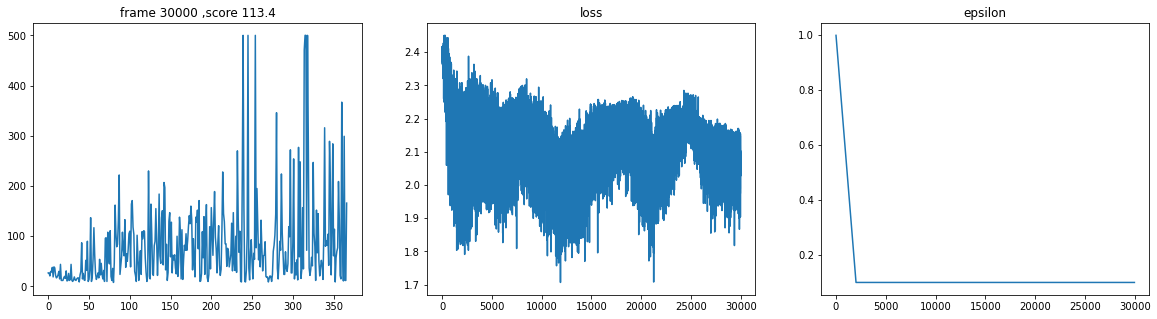

In [8]:
agent.train(num_frames=num_frames) # 训练模型并输出训练过程图像

## Test

In [9]:
video_folder="videos/Categorical Dqn"
agent.test(video_folder=video_folder)

D:\Anaconda3\envs\pytorch\lib\site-packages\gym\wrappers\record_video.py:41: UserWarning: WARN: Overwriting existing videos at C:\Users\20613\Desktop\14.Rainbow is all you need master\videos\Categorical Dqn folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
D:\Anaconda3\envs\pytorch\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] 无法在设置线程模式后对其加以更改。
  warnings.warn(str(err))


倒立摆一共维持500步。


## Render

In [10]:
import base64
import glob
import io
import os

from IPython.display import HTML, display


def ipython_show_video(path: str) -> None:
    """Show a video at `path` within IPython Notebook."""
    if not os.path.isfile(path):
        raise NameError("Cannot access: {}".format(path))

    video = io.open(path, "r+b").read()
    encoded = base64.b64encode(video)

    display(HTML(
        data="""
        <video width="320" height="240" alt="test" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4"/>
        </video>
        """.format(encoded.decode("ascii"))
    ))


def show_latest_video(video_folder: str) -> str:
    """Show the most recently recorded video from video folder."""
    list_of_files = glob.glob(os.path.join(video_folder, "*.mp4"))
    latest_file = max(list_of_files, key=os.path.getctime)
    ipython_show_video(latest_file)
    return latest_file

latest_file = show_latest_video(video_folder=video_folder)
print("Played:", latest_file)

Played: videos/Categorical Dqn\rl-video-episode-0.mp4


## Calculate running average and plot

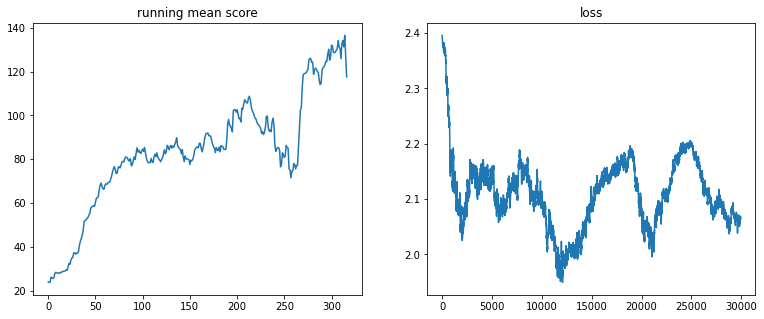

In [11]:
def running_mean(x,N=50):
    kernel = np.ones(N)
    conv_len = x.shape[0]-N
    y = np.zeros(conv_len)
    for i in range(conv_len):
        y[i] = kernel@x[i:i+N]
        y[i]/=N
    return y

score = running_mean(np.array(agent.scores)) # 得到分数
loss = running_mean(np.array(agent.losses))  # 得到损失

clear_output(wait=True)
plt.figure(figsize=(20,5)) # 设置规模为20X5大小的画布，并绘制三张图像
plt.subplot(131)
plt.title("running mean score") 
plt.plot(score)
plt.subplot(132)
plt.title("loss")
plt.plot(loss)
plt.show() # 显示图像